In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

import geopandas

# Introduction

This is a [notebook for students in Analysis in GIS](https://github.com/thomaspingel/analysis_in_gis/blob/master/coronavirus.ipynb) to explore data about COVID-19.  We'll be using data from the [New York Times](https://github.com/nytimes/covid-19-data), but other data is available as well, including:
* https://github.com/CSSEGISandData/COVID-19
* https://github.com/RamiKrispin/coronavirus



# Prepare Data

In [2]:
gdf = geopandas.read_file('https://github.com/thomaspingel/geodata/raw/master/election/election.gpkg',dtype={"FIPS":str})
chr_data = pd.read_csv('https://github.com/thomaspingel/geodata/raw/master/county_health_rankings/chr_2019.csv',dtype={'FIPS':str})
cv = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv',dtype={'fips':str})
cv.date = pd.to_datetime(cv.date)
cv.head()

C:\Anaconda3\envs\analysis_in_gis\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [3]:
# Filter by date?

cv = cv[(cv['date'] > '2020-01-01') & (cv['date'] < '2022-01-01')]

<AxesSubplot:xlabel='date'>

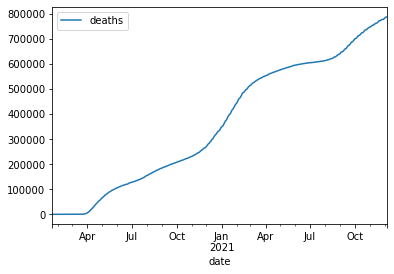

In [4]:
# Plot deaths

by_date = pd.DataFrame(cv.groupby('date').sum()).reset_index()
by_date.plot(x='date',y='deaths')

In [5]:
# Group totals by fips.  Since the data is cumulative, use the max.

cv_grouped = pd.DataFrame(cv.groupby('fips').max()).reset_index()
cv_grouped.head()

,fips,date,county,state,cases,deaths
0,01001,2021-12-06,Autauga,Alabama,10562,157.0
1,01003,2021-12-06,Baldwin,Alabama,38215,589.0
2,01005,2021-12-06,Barbour,Alabama,3708,80.0
3,01007,2021-12-06,Bibb,Alabama,4364,95.0
4,01009,2021-12-06,Blount,Alabama,10791,193.0


# Merge together

In [6]:
df = gdf.copy()
df = df.merge(chr_data,how='left',on='FIPS')
df = df.merge(cv_grouped,how='left',left_on='FIPS',right_on='fips')
np.shape(df)

(3221, 210)

In [7]:
print(df.columns.values)

['GEOID' 'NAME' 'STUSPS' 'STATE_NAME' 'FIPS' 'gop_2000_votes'
 'dem_2000_votes' 'totalvotes_2000' 'gop_2000_prc' 'dem_2000_prc'
 'gop_minus_dem_prc_2000' 'gop_2004_votes' 'dem_2004_votes'
 'totalvotes_2004' 'gop_2004_prc' 'dem_2004_prc' 'gop_minus_dem_prc_2004'
 'gop_2008_votes' 'dem_2008_votes' 'totalvotes_2008' 'gop_2008_prc'
 'dem_2008_prc' 'gop_minus_dem_prc_2008' 'gop_2012_votes' 'dem_2012_votes'
 'totalvotes_2012' 'gop_2012_prc' 'dem_2012_prc' 'gop_minus_dem_prc_2012'
 'gop_2016_votes' 'dem_2016_votes' 'totalvotes_2016' 'gop_2016_prc'
 'dem_2016_prc' 'gop_minus_dem_prc_2016' 'gop_2020_votes' 'dem_2020_votes'
 'totalvotes_2020' 'gop_2020_prc' 'dem_2020_prc' 'gop_minus_dem_prc_2020'
 'geometry' 'State' 'County'
 'Premature death - Years of Potential Life Lost Rate'
 'Premature death - YPLL Rate (Black)'
 'Premature death - YPLL Rate (Hispanic)'
 'Premature death - YPLL Rate (White)' 'Poor or fair health - % Fair/Poor'
 'Poor physical health days - Physically Unhealthy Days'
 'Poor 

In [8]:
df['deaths_per_thousand'] = 1000 * df.deaths / df['Demographics - Population']
df['cases_per_thousand'] = 1000 * df.cases / df['Demographics - Population']

df['calc_area'] = (df.geometry.to_crs(epsg=8857).area) / 1000**2
df['lat'] = df.centroid.apply(lambda p: p.y)
df['lon'] = df.centroid.apply(lambda p: p.x)

df['population_density'] = df['Demographics - Population'] / df.calc_area

C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_18248/2923341954.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = df.centroid.apply(lambda p: p.y)
C:\Users\THOMAS~1\AppData\Local\Temp/ipykernel_18248/2923341954.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = df.centroid.apply(lambda p: p.x)


In [9]:
# Write out if desired.  This may take a while.  An error in the GeoPackage write led me to choose GeoJSON, but 
# TODO is to troubleshoot that error.

# df.to_file('coronavirus.geojson',driver='GeoJSON')

# Analyze

## Map

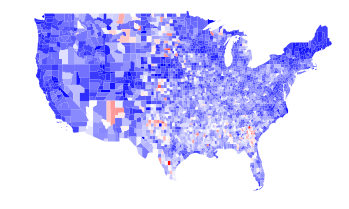

In [10]:
df.plot(column='deaths_per_thousand',cmap='bwr')
plt.xlim(-130,-65)
plt.ylim(23,50)
_ = plt.axis('off')

## Single Variable

In [11]:
y = 'deaths_per_thousand'
x = 'lat'

C:\Anaconda3\envs\analysis_in_gis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lat', ylabel='deaths_per_thousand'>

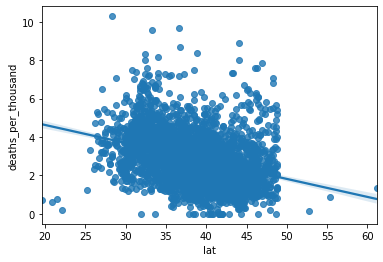

In [12]:
seaborn.regplot(x,y,data=df)

In [13]:
_df = df.loc[:,[x,y]]
_df = _df.dropna(how='any')

r, p = stats.pearsonr(_df[x],_df[y])
print('Pearson r = ',r,'P = ',p)

r,p = stats.spearmanr(_df[x],_df[y])
print('Spearman r = ',r,'P = ',p)

Pearson r =  -0.33841179585050524 P =  3.4593524674775144e-84
Spearman r =  -0.38804420074353557 P =  2.652688616447238e-112


In [14]:
_df = pd.DataFrame()
_df['x'] = df.loc[:,x]
_df['y'] = df.loc[:,y]
_df = _df.dropna(how='any')

# Then run the regression
results = smf.ols(formula='y ~ x',data=_df).fit()

# Print the report
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     402.0
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.46e-84
Time:                        10:31:34   Log-Likelihood:                -5171.9
No. Observations:                3110   AIC:                         1.035e+04
Df Residuals:                    3108   BIC:                         1.036e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4986      0.180     36.093      0.0

## Multiple Regression

In [15]:
y = 'deaths_per_thousand'

x0 = 'gop_minus_dem_prc_2020'
x1 = 'Flu vaccinations - % Vaccinated'
x2 = 'lat'

In [16]:
# A full model

_df = pd.DataFrame()
_df['x0'] = df.loc[:,x0]
_df['x1'] = df.loc[:,x1]
_df['x2'] = df.loc[:,x2]
_df['y'] = df.loc[:,y]
_df = _df.dropna(how='any')

# Then run the regression
results = smf.ols(formula='y ~ x0*x1*x2',data=_df).fit()

# Print the report
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     126.8
Date:                Tue, 07 Dec 2021   Prob (F-statistic):          2.18e-164
Time:                        10:31:34   Log-Likelihood:                -4953.1
No. Observations:                3104   AIC:                             9922.
Df Residuals:                    3096   BIC:                             9970.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3713      0.983      9.532      0.0